In [1]:
import sys
sys.path.append('../utils')


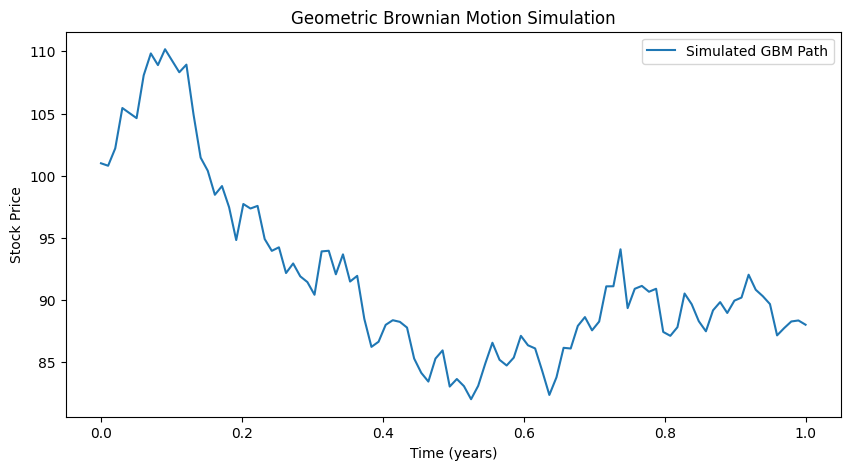

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from payoff import payoff_func


# Parameters for the GBM
S0 = 100  # Initial stock price
mu = 0.1  # Drift (expected return)
sigma = 0.2  # Volatility (standard deviation of returns)
T = 1.0  # Time period in years
dt = 0.01  # Time step size
N = int(T / dt)  # Number of time steps
t = np.linspace(0, T, N)  # Time grid

# Simulating the GBM
np.random.seed(42)  # For reproducibility
W = np.random.normal(0, np.sqrt(dt), N)  # Brownian increments
W = np.cumsum(W)  # Cumulative sum to get Brownian motion

# Compute the stock prices using GBM formula
S = S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W)

plt.figure(figsize=(10, 5))
plt.plot(t, S, label='Simulated GBM Path')
plt.title('Geometric Brownian Motion Simulation')
plt.xlabel('Time (years)')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

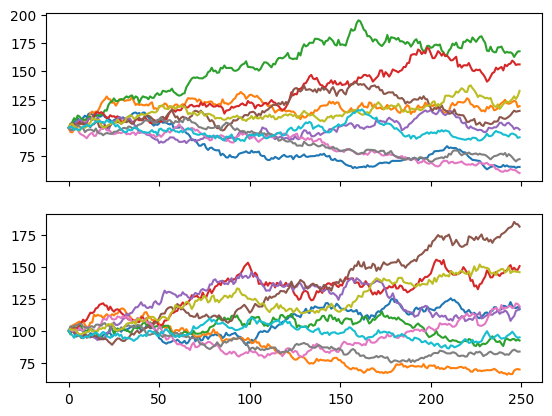

In [11]:
import numpy as np
import matplotlib.pyplot as pl

# returns ndarray with the following dimensions: nProcesses, nPaths, nSteps
def GeneratePaths(spot, process, maturity, nSteps, nPaths, correlation = None):
    dt = maturity / nSteps
    
    # case: given correlation matrix, create paths for multiple correlated processes
    if (isinstance(correlation, np.ndarray)):
        nProcesses = process.shape[0]
        result = np.zeros(shape = (nProcesses, nPaths, nSteps))
        
        # loop through number of paths
        for i in range(nPaths):
            # create one set of correlated random variates for n processes
            choleskyMatrix = np.linalg.cholesky(correlation)
            e = np.random.normal(size = (nProcesses, nSteps))            
            paths = np.dot(choleskyMatrix, e)
            # loop through number of steps
            for j in range(nSteps):
                # loop through number of processes
                for k in range(nProcesses):
                    # first path value is always current spot price
                    if(j == 0):
                        result[k, i, j] = paths[k, j] = spot[k]
                    else:
                        # use SDE lambdas (inputs: previous spot, dt, current random variate)
                        result[k, i, j] = paths[k, j] = process[k](paths[k, j - 1], dt, paths[k, j])

    # case: no given correlation matrix, create paths for a single process
    else:
        result = np.zeros(shape = (1, nPaths, nSteps))
        # loop through number of paths
        for i in range(nPaths):
            # create one set of random variates for one process
            path = np.random.normal(size = nSteps)
            # first path value is always current spot price
            result[0, i, 0] = path[0] = spot
            # loop through number of steps
            for j in range(nSteps):
                if(j > 0):
                    # use SDE lambda (inputs: previous spot, dt, current random variate)
                    result[0, i, j] = path[j] = process(path[j - 1], dt, path[j])
    return result

# Geometric Brownian Motion parameters
r = 0.03
v = 0.25

# define lambda for process (inputs: spot, dt, random variate)
BrownianMotion = lambda s, dt, e: s + r * s * dt + v * s * np.sqrt(dt) * e   

# general simulation-related parameters
maturity = 1.0
nPaths = 10
nSteps = 250

# case: one process
# SingleAssetPaths = GeneratePaths(100.0, BrownianMotion, maturity, nSteps, nPaths)
# for i in range(nPaths):
#     pl.plot(SingleAssetPaths[0, i, :])
# pl.show()

# case: two correlated processes
matrix = np.array([[1.0, 0.5, 0], [0.5, 1.0, 0.5], [0, 0.5, 1.0]])
spots = np.array([100.0, 100.0, 100.0])
processes = np.array([BrownianMotion, BrownianMotion, BrownianMotion])
MultiAssetPaths = GeneratePaths(spots, processes, maturity, nSteps, nPaths, matrix)
f, subPlots = pl.subplots(processes.shape[0], sharex = True)
for i in range(processes.shape[0]): 
    for j in range(nPaths):
        subPlots[i].plot(MultiAssetPaths[i, j, :])
pl.show()

In [12]:
MultiAssetPaths.shape


(2, 10, 250)